## Introduction

This notebook simulates freight trips and generates a freight population file. In this notebook, we assume LGVs represent last-mile deliveries to customers. We do not assume LGVs are used for other purposes such as construction, maintenance, or other purposes that require an LGV. We may want to revisit subpopulations for LGVs that have different behaviours.

The methodology follows the below steps: <br>
Estimate # of LGVs per hour **->** Assign # of Stops **->** Decide Location & Sequence of Stops **->** Determine Trip & Stop Duration

The following steps are undertaken:

1. Read, process, and plot data.
2. Input Assumptions
3. Create Samplers
4. Create Activity Model & Population
5. Validation

In [1]:
import pandas as pd
import geopandas as gp
from copy import deepcopy
import matplotlib
from matplotlib import pyplot as plt
import random
from datetime import date
import numpy as np
from shapely.geometry import Point, Polygon
import os
import scipy
from scipy import spatial


import pam
from pam.core import Population, Household, Person
from pam import read
from pam.plot.stats import plot_activity_times, plot_leg_times

import pam.samplers
from pam.samplers.basic import freq_sample
from pam.samplers.spatial import RandomPointSampler
from pam.samplers.facility import FacilitySampler
from pam.samplers import facility
from pam.samplers import tour

from pam import write
#from pam.activity import Plan, Activity, Leg
from pam.utils import minutes_to_datetime as mtdt
from pam.variables import END_OF_DAY
from pam.write import write_matsim, write_od_matrices, write_duration_benchmark, write_distance_benchmark, to_csv

# import warnings
# warnings.filterwarnings('ignore')

matplotlib.style.use('ggplot')

We keep a data register on S3. The data register is a csv file with information on each file input, such as:

    - a short description of each file,
    - the data source,
    - the path to the file on S3,
    - date created/updated,
    - a recommended variable name to be used in analysis
    - etc


In [2]:
output_path = './data/outputs'

## 1. Read, process, plot Data
Loading in necessary from data register. In this case, zones and freight facility data.

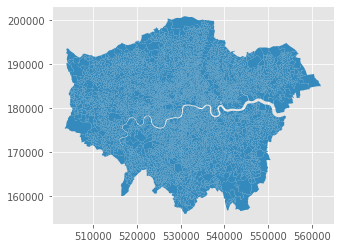

In [3]:
zones = gp.read_file('./data/lsoas/LSOA_2004_London_Low_Resolution.shp')
# we need to convert zones to a "m" grid crs such that can measure things in metres in matsim later

zones.rename(columns={'LSOA_CODE':'zone'}, inplace=True)
zones.plot()
plt.show()

<AxesSubplot:>

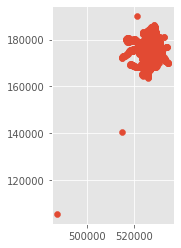

In [4]:
# load facilities
facilities = gp.read_file('./data/londinium_facilities_epsg_27700.geojson')
facilities.set_crs('EPSG:27700', allow_override=True, inplace=True)
#facilities.to_crs("EPSG:4326", inplace=True)

# dummy create depots and deliveries
facilities['activity'] = np.where(facilities['activity']=='work', 'depot', facilities['activity'])
facilities['activity'] = np.where(facilities['activity']=='pub', 'delivery', facilities['activity'])

facilities.plot()

In [5]:
cols = list(zones.columns)
#cols
# limit zones to only those in Londinium data
zones_londinium = gp.sjoin(zones, facilities, how='inner', predicate='intersects')
zones_londinium = zones_londinium[cols]
zones = zones_londinium.drop_duplicates()
#zones.head()

/var/folders/fg/4rbdps2s6ss9r2455xhzwd4sswl1dp/T/ipykernel_68787/2029463096.py:4: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...
Right CRS: EPSG:27700




In [6]:
zones = zones.set_index('zone')

In [7]:
facility_sampler = FacilitySampler(
    facilities=facilities,
    zones=zones,
    build_xml=True,
    fail=False,
    random_default=True
)

facility_sampler.activities

Joining facilities data to zones, this may take a while.
/var/folders/fg/4rbdps2s6ss9r2455xhzwd4sswl1dp/T/ipykernel_68787/930579154.py:1: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

/Users/divya.sharma/Documents/repos/pam/pam/samplers/facility.py:149: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...


Building sampler, this may take a while.


['delivery',
 'transit',
 'depot',
 'home',
 'other',
 'gym',
 'education',
 'leisure',
 'medical',
 'park',
 'shop']

Using random sample for zone:E01001355:depot


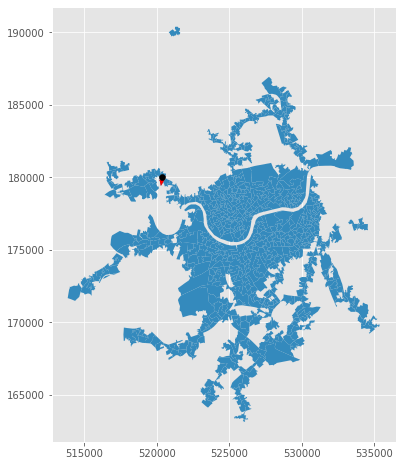

In [8]:
# Spider.
def plot_facility(zone_idx, activity):
    
    fig, ax = plt.subplots(figsize=(8,8))
    zones.plot(ax=ax)
    zones.loc[[zone_idx]].plot(color='red', ax=ax)
    
    facility_sampler.clear()
    point = facility_sampler.sample(zone_idx, activity)
    ax.scatter(point.x, point.y, color='black')
    plt.show()
    
plot_facility(random.choice(zones.index), 'depot')

## 2. Input Assumptions

We create assumptions for the below six assumptions. The number of stops, first delivery of the day, and stop location all use a random sampler weighted on frequency.

1. **Number of Stops** <br>
    We've created a distribution based on this [research](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8569747&casa_token=RMr4Ks4RW4cAAAAA:deDYHpQBROY5lgm1qq8swaGhUfCandFV3dKr4Xpn-CghIHQ8Po-COmcm4NvvFKuUhGNJ7o0&tag=1). However, we need to validate with other datasets to determine if it is possible for deliveries to have 1 or 2 stops. The current assumption is a delivery has a minimum of 3 stops.

2. **Freight Tours & Delivery Time of Day** <br>
    Sourced from HK team [link](https://arup.sharepoint.com/:x:/s/IIA24236/EdHNl457U6pNrSD2d2k6HQUBYJwzmlPLkqoYXbApCpyO7w?e=R0X0tE), defined as Goods Vans that are not HGV or MGV.

    For time of day, we combine data from HK Traffic Flow Census Data [link](https://data.gov.hk/en-data/dataset/hk-td-tis_7-traffic-flow-census/resource/ef0f18ee-8ad4-4a4f-bf74-602c93a4e1f7) and the number of LGV Tours. Currently utilising Hong Kong Internal Cordon data as a reference. The LGV proporition is calculated [here](https://arup.sharepoint.com/:x:/s/IIA24236/EUGvbQ7q7StIi0DT6owCYFwBnKuUvo6zVHE-e8kP3_o70w?e=xDfnx0).


3. **Input Demand & Constraints** <br>
    Input demand is the density of depot origins and delivery destinations. Constraints are the distance between zones, expressed by an origin/destination dataframe.

#### 1. Number of Stops & Stop Sampler
Build a Stop Number distribution and corresponding sampler.

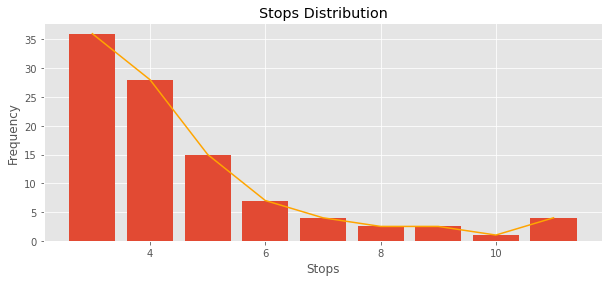

In [9]:
# Create Stop Distribution
bins = range(3,12)
pivots = {3: 36.0, 4: 28.0, 5: 15.0, 6: 7.0, 7: 4.0, 8: 2.5, 9: 2.5, 10: 1.0, 11: 4.0}
stops_dist = tour.CreateDistribution().build_distribution(bins=bins, pivots=pivots)
tour.CreateDistribution().plot_distribution(stops_dist, 'Stops Distribution', 'Stops', 'Frequency')

In [10]:
# Sample Number of stops
stop_sampler = tour.FrequencySampler(list(stops_dist.keys()), list(stops_dist.values()))
stop_sampler.sample()

4

#### 2. Freight Tours & Distribution
The number of freight tours is derived from the HK Goods Van matrix data.
The distribution of freight trips per hour is based on the HK Census counter data. However, there is not counting data from 11pm to 7am (overnight). Therefore, a simple linear model is applied for those hours via the CreateDistribution object.

In [11]:
# Set up freight params for both LGV and hgv movements

lgv_params = {'total':500000,
              'pivots': {7: 14, 8 :9, 9: 13, 10: 16, 11: 18, 12: 13, 13: 15, 14: 16, 15: 14, 16: 13, 17: 9, 18: 5, 19: 3, 20: 3, 21: 3, 22: 2},
              'agent_id': 'LGV',
              'agent_attributes': 'lgv'
              }

hgv_params = {'total':250000,
              'pivots': {7: 2, 8: 1, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 1, 17: 1, 18: 0, 19: 1, 20: 1, 21: 1, 22: 1},
              'agent_id': 'HGV',
              'agent_attributes': 'hgv'
              }

In [12]:
# We choose to create a population for LGV.
freight_params = lgv_params.copy()

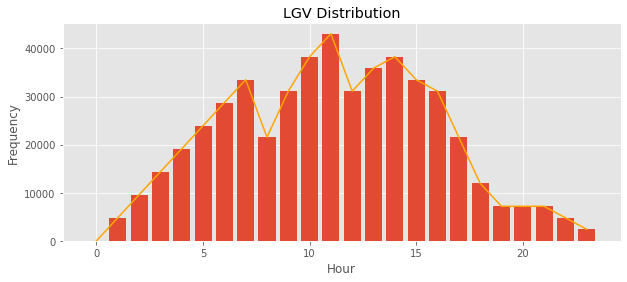

In [13]:
# Create LGV Distribution
bins = range(0,24)

freight_dist = tour.CreateDistribution().build_distribution(bins=bins, pivots=freight_params['pivots'], total=freight_params['total'])
tour.CreateDistribution().plot_distribution(freight_dist, f"{freight_params['agent_id']} Distribution", 'Hour', 'Frequency')

#### 3. Input Demand & Constraints
Calculate the density of depots and deliveries across all zones. Merge this with the zones table to obtain the geometry and calculate the distance between each zone.

In [14]:
zones = zones.reset_index()

In [15]:
# Input Demand, in this case defined as facility density location
depot_density, delivery_density = tour.InputDemand().facility_density(facilities=facilities,
                                                                      zones=zones,
                                                                      zone_id='zone',
                                                                      o_activity='depot',
                                                                      d_activity='delivery')

/Users/divya.sharma/Documents/repos/pam/pam/samplers/tour.py:113: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...




In [16]:
# Constraint, defined as distance between origin and destination centroids                                                                    

zones_list = zones.centroid.apply(lambda x: [x.x, x.y]).to_list()
od_matrix = spatial.distance_matrix(x=zones_list, y=zones_list)
df_od = pd.DataFrame(od_matrix, index=zones.zone, columns=zones.zone)

#df_od.head()

## 3. Samplers

In [17]:
# test sampling an hour from this distribution
hour_sampler = tour.FrequencySampler(list(freight_dist.keys()), list(freight_dist.values()))
hour_sampler.sample()

4

In [18]:
# test same a minute
minute_sampler = tour.FrequencySampler(range(60))
minute_sampler.sample()

46

In [19]:
# Sample Number of stops
stop_sampler = tour.FrequencySampler(list(stops_dist.keys()), list(stops_dist.values()))
stop_sampler.sample()

5

In [20]:
# Sample origin based on density table
ozone_sampler = tour.FrequencySampler(list(depot_density['zone']), list(depot_density['density']))
ozone_sampler.sample()

'E01003037'

## 4. Activity Modeller

Assumptions and samplers are applied to build a population of activity plans.

Key assumptions of note:

- we take total demand from the hourly distribution and divide by 2 - this assumes a reciprocating return trip
- we create 2 activity types: depot and delivery
- we model depot departure time by sampling from hourly demand
- if a delivery end is estimated to go beyond 24 hours, we have the driver return to the depot instead.

Activities are encoded as "car". Subpopulation is encoded as "lgv" or "hgv".

A plan is modelled by the following functions:
- tour_activity: Adds the activity of a new delivery
- tour_leg: Adds the leg of travel to the new delivery
- return_depot: combines the two above to return from the last delivery to the origin depot

### Population Parameters

In [21]:
#Factor to scale trips (To better match validation counts when needed)
factor = 1 #0.70

#List
#samples = [0.0001]
samples = [0.01]
#samples = [0.10]

# Set Distance threshold, in this case arbitrarily set to median distance of od dataframe.
dist_threshold = df_od.median().agg('median')

# Set activity parameters
speed = 40000/3600 # 50km/hr
maxi = 3600
mini = 600


# #create export directory if it doesn't exist
# if os.path.isdir(output_path)==False:
#     os.mkdir(output_path)

In [22]:
# used for fnames
today = date.today().strftime('%d%b%y')
today

'09May22'

In [23]:
#### Sample Agents
# Considered bundling this into the tour script, but decided too many variables would need to be passed. This felt like over-engineering.
def sample_agents(size):
    
    facility_sampler.clear()
    population = Population()
    
    # make below into an LGV/HGV function: freight_sampler.
    for i in range(size):

        agent_id = f"{freight_params['agent_id']}_{i}"

        # have to add hh to keep pam happy even though makes no sense in this case
        # might try to abstract this away in future
        hh = Household(agent_id)
        
        agent = Person(
            agent_id,
            attributes={
                'subpopulation': freight_params['agent_attributes'],
                'CarType': freight_params['agent_attributes'],
                'CarCO2': freight_params['agent_attributes']
            }
        )
        
        hh.add(agent)
        population.add(hh)

        hour = hour_sampler.sample()
        minute = minute_sampler.sample()

        # o_zone = ozone_sampler.sample()
        # o_loc = facility_sampler.sample(o_zone, 'depot')

        if freight_params['agent_id']=='LGV':
            stops = stop_sampler.sample()
        else:
            stops = 1

        o_zone, o_loc, d_zone, d_loc = tour.TourSequence().stop_sequence(stops=stops,
                                                          d_density=delivery_density, 
                                                          ozone_sampler=ozone_sampler, 
                                                          df_od=df_od, 
                                                          dist_threshold=dist_threshold, 
                                                          dist_id='distance', 
                                                          zone_id='zone',
                                                          facility_sampler=facility_sampler,
                                                          o_activity = 'depot',
                                                          d_activity='delivery')

        time_params = {'hour':hour, 'minute':minute}
        end_tm = tour.TourPlan().tour_activity(agent=agent, k=1, zone=o_zone, loc=o_loc, activity_type='depot', time_params=time_params)

        # Build a Tour Plan utilising ActivityDuration and TourPlan objects.

        for k in range(stops):
            # Currently, we assume stop duration ranges from 10 minutes, 100% of the journey time, or 60 minutes.
            stop_duration, start_tm, end_tm = tour.ActivityDuration().activity_duration(o_loc, d_loc[k], end_tm, speed, maxi, mini)
            if mtdt(end_tm) > END_OF_DAY:
                #print(f'End of Day Agent {agent}, return to depot')
                break
            elif k == 0:
                end_tm = tour.TourPlan().tour_leg(agent=agent, k=k, o_zone=o_zone, o_loc=o_loc, d_zone=d_zone, d_loc=d_loc[k], start_tm=start_tm, end_tm=end_tm)

                time_params = {'end_tm':end_tm, 'stop_duration':stop_duration}
                end_tm = tour.TourPlan().tour_activity(agent=agent, k=k, zone=d_zone, loc=d_loc[k], activity_type='delivery', time_params=time_params)
            else: 
                end_tm = tour.TourPlan().tour_leg(agent=agent, k=k, o_zone=d_zone, o_loc=d_loc[k-1], d_zone=d_zone, d_loc=d_loc[k], start_tm=start_tm, end_tm=end_tm)

                time_params = {'end_tm':end_tm, 'stop_duration':stop_duration}
                end_tm = tour.TourPlan().tour_activity(agent=agent, k=k, zone=d_zone, loc=d_loc[k], activity_type='delivery', time_params=time_params)
        
        end_tm = tour.TourPlan().return_depot(agent=agent, k=stops, o_zone=o_zone, o_loc=o_loc, d_zone=d_zone, d_loc=d_loc[stops-1], end_tm=end_tm, speed=speed)
        
    return population


In [24]:
# Function to build population 

def build_population(sample, factor):
    population = sample_agents(int(factor * int(freight_params['total'] * sample)))
    
    return population

In [25]:
# Build + Crop + Write Population for samples
for s in samples:
    
    #build
    population = build_population(s, factor)
        
    #Crop and Validate Plans
    population.fix_plans()
    population.validate()

    # Write to Disk
    xml_comment = f"prelim {s*100}% {freight_params['agent_id']} {today}"
    output_path = os.path.join(output_path)
    #create export directory if it doesn't exist
    # if os.path.isdir(output_path)==False:
    #     os.mkdir(output_path)
    
    write_matsim(
        population,
        os.path.join(output_path, "plans.xml"),
        os.path.join(output_path, "attributes.xml"),
        comment=xml_comment
    )

    population.to_csv(output_path, crs = "EPSG:2326", to_crs="EPSG:4326")
    # ignore all the "failed to find home" logging (it is not relevant and will be removed in future)

    facility_sampler.write_facilities_xml(
       os.path.join(output_path, "facilities.xml"),
       comment=xml_comment
    )

Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending in Leg
Cropping plan components
Cropping plan ending 

## 5. Validation

Person: LGV_3420
{'subpopulation': 'lgv', 'CarType': 'lgv', 'CarCO2': 'lgv', 'hid': 'LGV_3420'}
0:	Activity(1 act:depot, location:POINT (530583.856957753 178832.6802506062), time:00:00:00 --> 11:51:00, duration:11:51:00)
1:	Leg(1 mode:car, area:POINT (530583.856957753 178832.6802506062) --> POINT (530511.8443963701 176453.71680244073), time:11:51:00 --> 11:55:00, duration:0:04:00)
2:	Activity(2 act:delivery, location:POINT (530511.8443963701 176453.71680244073), time:11:55:00 --> 12:05:00, duration:0:10:00)
3:	Leg(2 mode:car, area:POINT (530511.8443963701 176453.71680244073) --> POINT (529438.3096999731 175233.02315186223), time:12:05:00 --> 12:12:00, duration:0:07:00)
4:	Activity(3 act:delivery, location:POINT (529438.3096999731 175233.02315186223), time:12:12:00 --> 12:22:00, duration:0:10:00)
5:	Leg(3 mode:car, area:POINT (529438.3096999731 175233.02315186223) --> POINT (528610.886625979 178743.5102372764), time:12:22:00 --> 12:26:00, duration:0:04:00)
6:	Activity(4 act:delivery, lo

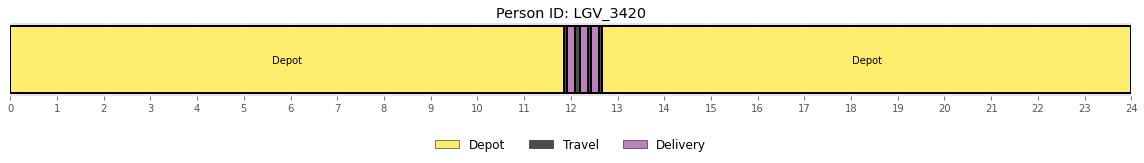

Person: LGV_4713
{'subpopulation': 'lgv', 'CarType': 'lgv', 'CarCO2': 'lgv', 'hid': 'LGV_4713'}
0:	Activity(1 act:depot, location:POINT (525453.2396095932 179491.82899516902), time:00:00:00 --> 20:33:00, duration:20:33:00)
1:	Leg(1 mode:car, area:POINT (525453.2396095932 179491.82899516902) --> POINT (526861.7561180707 176700.38505164383), time:20:33:00 --> 20:39:00, duration:0:06:00)
2:	Activity(2 act:delivery, location:POINT (526861.7561180707 176700.38505164383), time:20:39:00 --> 20:49:00, duration:0:10:00)
3:	Leg(2 mode:car, area:POINT (526861.7561180707 176700.38505164383) --> POINT (529781.3620092889 175520.51640498248), time:20:49:00 --> 21:01:00, duration:0:12:00)
4:	Activity(3 act:delivery, location:POINT (529781.3620092889 175520.51640498248), time:21:01:00 --> 21:13:00, duration:0:12:00)
5:	Leg(3 mode:car, area:POINT (529781.3620092889 175520.51640498248) --> POINT (527674.549675533 175133.17310079286), time:21:13:00 --> 21:23:00, duration:0:10:00)
6:	Activity(4 act:deliver

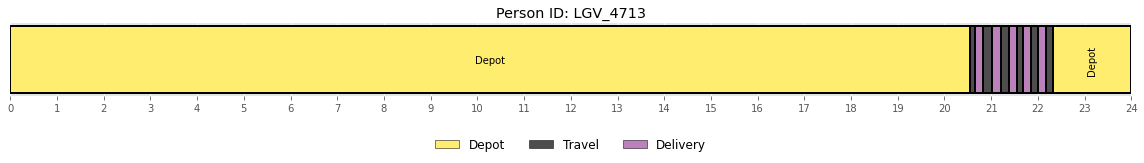

Person: LGV_4680
{'subpopulation': 'lgv', 'CarType': 'lgv', 'CarCO2': 'lgv', 'hid': 'LGV_4680'}
0:	Activity(1 act:depot, location:POINT (529096.1211205482 178146.8842693082), time:00:00:00 --> 04:34:00, duration:4:34:00)
1:	Leg(1 mode:car, area:POINT (529096.1211205482 178146.8842693082) --> POINT (527290.6065179455 178806.49014235998), time:04:34:00 --> 04:38:00, duration:0:04:00)
2:	Activity(2 act:delivery, location:POINT (527290.6065179455 178806.49014235998), time:04:38:00 --> 04:48:00, duration:0:10:00)
3:	Leg(2 mode:car, area:POINT (527290.6065179455 178806.49014235998) --> POINT (529467.7969659186 178899.00990389253), time:04:48:00 --> 04:49:00, duration:0:01:00)
4:	Activity(3 act:delivery, location:POINT (529467.7969659186 178899.00990389253), time:04:49:00 --> 04:59:00, duration:0:10:00)
5:	Leg(3 mode:car, area:POINT (529467.7969659186 178899.00990389253) --> POINT (526770.2531301157 178776.24074915648), time:04:59:00 --> 05:04:00, duration:0:05:00)
6:	Activity(4 act:delivery,

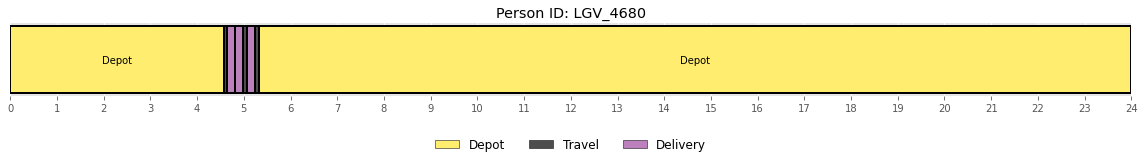

In [26]:
for i in range(3):
    p = population.random_person()
    p.plot()
    p.print()
    plt.show()

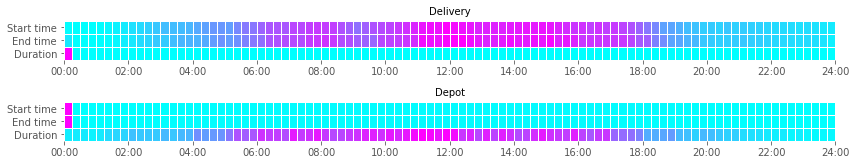

In [27]:
from pam.plot.stats import plot_activity_times, plot_leg_times
fig = plot_activity_times(population)
plt.show()

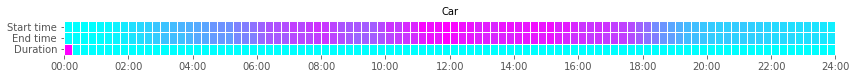

In [28]:
fig = plot_leg_times(population)
plt.show()

In [29]:
trips = pd.read_csv(os.path.join(output_path,"legs.csv"))

def get_hour(dt):
    return int(dt.split(" ")[1].split(":")[0])

trips["start_hour"] = trips["tst"].apply(get_hour)
trips.head()

,Unnamed: 0,pid,hid,freq,ozone,dzone,purp,origin activity,destination activity,mode,seq,tst,tet,duration,start_hour
0,0,LGV_0,LGV_0,NaN,E01004509,E01004558,NaN,depot,delivery,car,1,1900-01-01 17:17:00,1900-01-01 17:26:00,0:09:00,17
1,1,LGV_0,LGV_0,NaN,E01004558,E01004558,NaN,delivery,delivery,car,2,1900-01-01 17:36:00,1900-01-01 17:40:00,0:04:00,17
2,2,LGV_0,LGV_0,NaN,E01004558,E01004558,NaN,delivery,delivery,car,3,1900-01-01 17:50:00,1900-01-01 17:57:00,0:07:00,17
3,3,LGV_0,LGV_0,NaN,E01004558,E01004558,NaN,delivery,delivery,car,4,1900-01-01 18:07:00,1900-01-01 18:10:00,0:03:00,18
4,4,LGV_0,LGV_0,NaN,E01004558,E01004509,NaN,delivery,depot,car,5,1900-01-01 18:20:00,1900-01-01 18:23:00,0:03:00,18


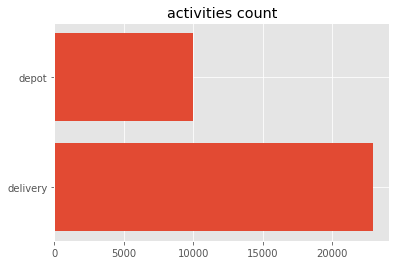

In [30]:
df_activity = pd.read_csv(os.path.join(output_path, "activities.csv"))
totals = df_activity.activity.value_counts()
plt.barh(totals.index, totals)
plt.title("activities count")
plt.show()

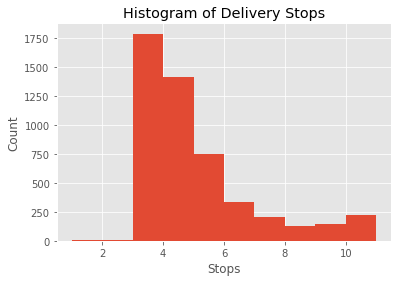

In [31]:
matplotlib.style.use('ggplot')

plot_data = df_activity[df_activity['activity']=='delivery'].groupby(['pid']).agg({'activity':'count'}).reset_index()
g = plt.hist(x = 'activity', data = plot_data)

plt.title('Histogram of Delivery Stops')
plt.xlabel('Stops')
plt.ylabel('Count')

plt.show()

In [32]:
delivery_count = df_activity[df_activity['activity']=='delivery'].groupby(['pid']).agg({'activity':'count'}).reset_index()
depot_count = df_activity[df_activity['activity']=='depot'].groupby(['pid']).agg({'activity':'count'}).reset_index()
print(f'Ratio of deliveries to depots {delivery_count.activity.sum()/depot_count.activity.sum()}')
delivery_count.describe()

Ratio of deliveries to depots 2.304509390378628


,activity
count,4998.000000
mean,4.591036
std,2.004202
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,11.000000


In [33]:
write_od_matrices(population, path = output_path)
od_matrices = pd.read_csv(os.path.join(output_path, "total_od.csv")) 

In [34]:
df_trips_o = trips[trips['origin activity']=='depot'].groupby(['ozone']).agg({'pid':'count'}).reset_index()
df_trips_o.rename(columns={'pid':'origin_trips'}, inplace=True)

df_trips_d = trips[trips['destination activity']=='delivery'].groupby(['dzone']).agg({'pid':'count'}).reset_index()
df_trips_d.rename(columns={'pid':'delivery_trips'}, inplace=True)

# Create a dataframe to plot od trips and compare against facility density and flows density.
pop_od = zones.copy()

# Merge in trips information
pop_od = pd.merge(pop_od, df_trips_o, left_on = 'zone', right_on = 'ozone', how = 'left')
pop_od = pd.merge(pop_od, df_trips_d, left_on = 'zone', right_on = 'dzone', how = 'left')

# Merge in density information
pop_od = pd.merge(pop_od, depot_density, left_on = 'zone', right_on = 'zone', how = 'left')
pop_od.rename(columns={'activity':'depot_activity','density':'depot_density'}, inplace=True)
pop_od = pd.merge(pop_od, delivery_density, left_on = 'zone', right_on = 'zone', how = 'left')
pop_od.rename(columns={'activity':'delivery_activity','density':'delivery_density'}, inplace=True)

pop_od.head()

,zone,LSOA_NAME,MSOA_CODE,MSOA_NAME,STWARDCODE,STWARDNAME,LA_CODE,LA_NAME,geometry,ozone,origin_trips,dzone,delivery_trips,depot_activity,depot_density,delivery_activity,delivery_density
0,E01000004,City of London 001D,E02000001,City of London 001,00AAFT,Farringdon Without,00AA,City of London,"POLYGON ((531172.252 181124.643, 531133.747 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E01000155,Barnet 030D,E02000053,Barnet 030,00ACGA,Colindale,00AC,Barnet,"POLYGON ((521244.473 190052.497, 521327.995 19...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E01000544,Brent 034A,E02000126,Brent 034,00AEGT,Kilburn,00AE,Brent,"MULTIPOLYGON (((524926.560 182943.202, 525035....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E01000550,Brent 034B,E02000126,Brent 034,00AEGT,Kilburn,00AE,Brent,"POLYGON ((525166.162 183404.390, 525126.000 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E01000552,Brent 034D,E02000126,Brent 034,00AEGT,Kilburn,00AE,Brent,"POLYGON ((525123.873 182986.770, 525125.563 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Trips from Depot (origin)')

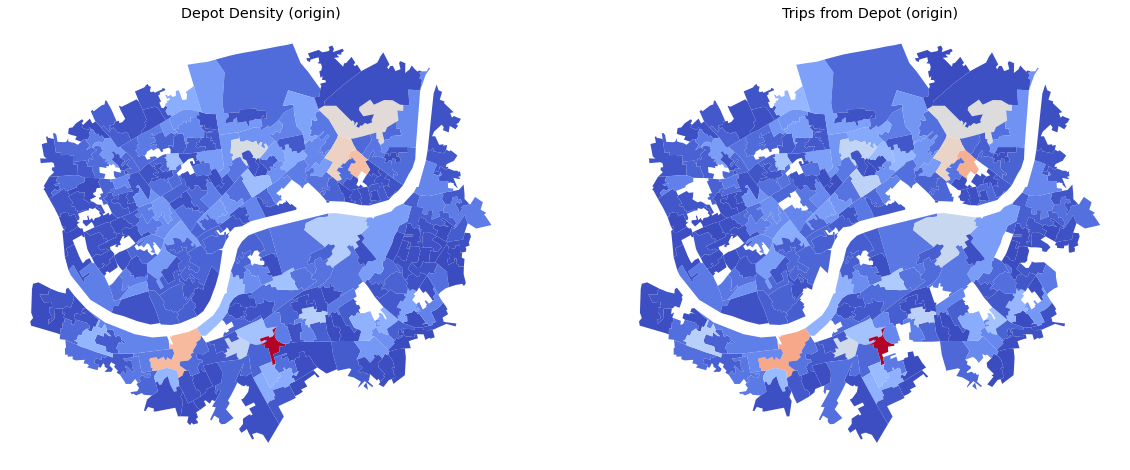

In [35]:
# Plot density, trips, and flows by zone.

fig, ax = plt.subplots(1, 2, figsize=(20,10))

pop_od.plot('depot_density', ax=ax[0], cmap='coolwarm')
ax[0].axis('off')
ax[0].set_title('Depot Density (origin)')

pop_od.plot('origin_trips', ax=ax[1], cmap='coolwarm')
ax[1].axis('off')
ax[1].set_title('Trips from Depot (origin)')

Text(0.5, 1.0, 'Trips to Delivery (destination)')

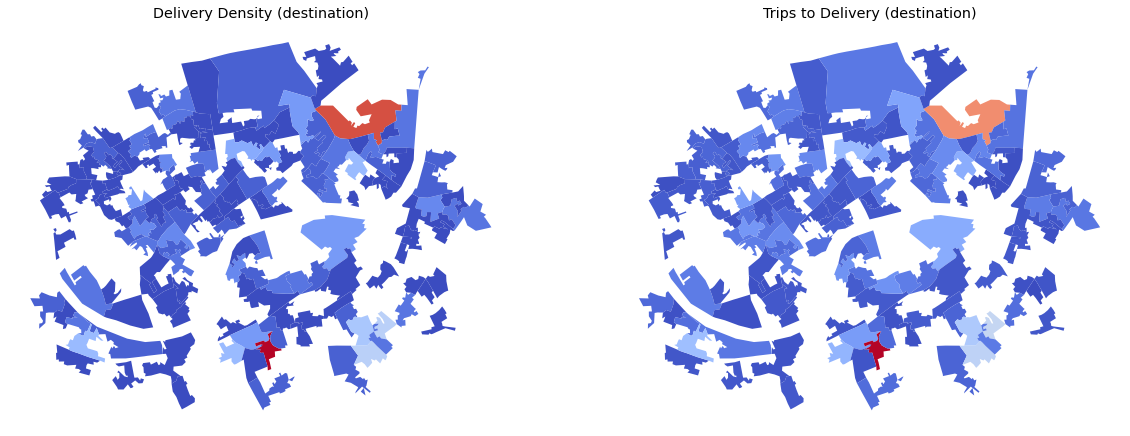

In [36]:
# Plot density, trips, and flows by zone.

fig, ax = plt.subplots(1, 2, figsize=(20,10))

pop_od.plot('delivery_density', ax=ax[0], cmap='coolwarm')
ax[0].axis('off')
ax[0].set_title('Delivery Density (destination)')

pop_od.plot('delivery_trips', ax=ax[1], cmap='coolwarm')
ax[1].axis('off')
ax[1].set_title('Trips to Delivery (destination)')

Text(0.5, 1.0, 'Delivery Density vs. Destination Trips')

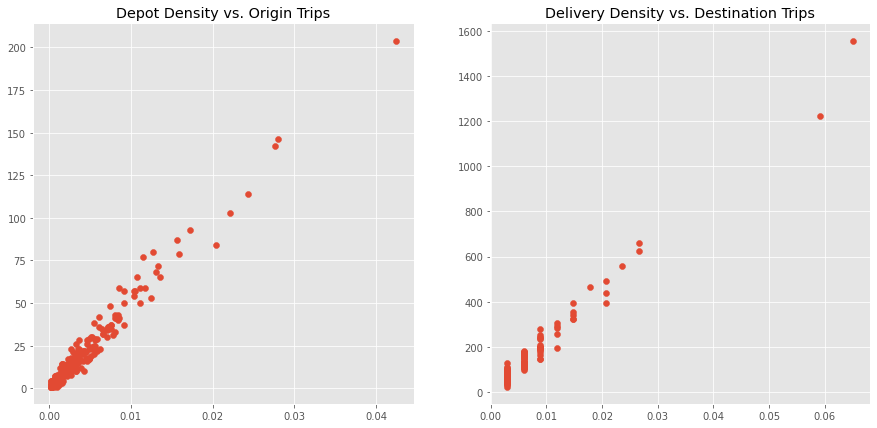

In [37]:
# Validate that as density increases, so do the number of trips for each zone.
fig, ax = plt.subplots(1, 2, figsize=(15,7))

ax[0].scatter(x='depot_density', y='origin_trips', data = pop_od)
ax[0].set_title('Depot Density vs. Origin Trips')

ax[1].scatter(x='delivery_density', y='delivery_trips', data = pop_od)
ax[1].set_title('Delivery Density vs. Destination Trips')

In [38]:
# write_matsim(
#         population,
#         os.path.join(output_path, "population.xml"),
#         os.path.join(output_path, "attributes.xml"),# Note the version12 don't have attributes
#         version=12
#     )